### Fingerprint

A técnica de Fingerprint envolve a criação de um banco de dados contendo amostras de informações, como potência do sinal, time advance e outros parâmetros que caracterizam uma determinada região. O conceito subjacente a esse algoritmo é utilizar esse banco de dados como um espaço de referência, no qual é possível comparar os sinais coletados em uma localização desconhecida com as informações armazenadas na base de dados. Isso permite estimar qual ponto da base de dados é mais similar à posição atual do objeto de interesse.

###  Solução:

O algoritmo de busca Fingerprint utiliza o cálculo da distância euclidiana, considerando as perdas em espaço livre das estações rádio base como características (features) e é inspirado no conceito de Fingerprint. Este algoritmo, baseado em machine learning, utiliza uma abordagem de regressão linear. Ele emprega as perdas em espaço livre das estações rádio base como entradas e tem como saída a estimativa da latitude e longitude do objeto de interesse.

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from branca.element import Figure
import folium

In [149]:
# Carregando os dados
df = pd.read_csv("../../project_files/03_processed_files/meds_train_alunos.csv")


In [150]:
df.head()


,Unnamed: 0.1,Unnamed: 0,id_ponto,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,num_lat_bts,num_long_bts,flag_indoor
0,0,0,6604,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.00,5.0,3.0,2.0,-8.055786,-34.951505,True
1,1,1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.12,5.0,3.0,2.0,-8.055784,-34.951608,True
2,2,2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.00,5.0,3.0,2.0,-8.055506,-34.951693,True
3,3,3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.27,4.0,7.0,2.0,-8.050390,-34.959630,False
4,4,4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.00,5.0,3.0,2.0,-8.055380,-34.951736,True


In [151]:
X = df[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]
y = df[['id_ponto','num_lat_bts', 'num_long_bts']]

In [152]:
# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Distância Euclidiana

In [153]:
import math

def vector_subtract(v,w):
    # Subtrai dois vetores e retorna o resultado.
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def dot(v,w):
    # Calcula o produto escalar de dois vetores.
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v):
    # Calcula a soma dos quadrados dos componentes de um vetor.
    return dot(v,v)

def magnitude(v):
    # Calcula a magnitude (ou comprimento) de um vetor.
    return math.sqrt(sum_of_squares(v))

def distance(v,w):
    # Calcula a distância euclidiana entre dois vetores.
    return magnitude(vector_subtract(v,w))

In [154]:
"""
    Estima a posição de um dispositivo com base em sua impressão digital (fingerprint).
    
    Parâmetros:
    - v: vetor de impressão digital do dispositivo.
    - df: DataFrame contendo as impressões digitais de referência e suas respectivas posições.
    
    Retorna:
    - A posição (latitude e longitude) da impressão digital de referência mais próxima do vetor v.
"""
def fingerprint(v, df):
    # Calcula a distância entre o vetor de impressão digital v e cada vetor no DataFrame.
    # A função distance é usada para calcular a distância, que precisa ser definida em algum lugar do código.
    df['distance'] = [distance(list(w), list(v)) for w in df.values.tolist()]
    
    # Ordena o DataFrame com base nas distâncias em ordem crescente.
    df = df.sort_values(by='distance', ascending=True)
    
    # Redefine o índice do DataFrame para que o índice 0 seja o vetor de impressão digital mais próximo.
    df = df.reset_index()
    
    # Retorna a latitude e a longitude da impressão digital de referência mais próxima.
    return df.loc[0, ['num_lat_bts', 'num_long_bts']]


In [155]:
v = [106,	122,	114,	123,	130,	111]
df_ = X_train.copy()
df_['num_lat_bts'] = y_train['num_lat_bts']
df_['num_long_bts'] = y_train['num_long_bts']
fingerprint(v,df_)

num_lat_bts     -8.05420
num_long_bts   -34.94651
Name: 0, dtype: float64

In [156]:
# Previsoes fingerprint
Y_pred = [list(fingerprint(v,df_)) for _,v in X_test.iterrows()]


In [157]:

df2 = y_test.copy()
df2['lat_pred'] = [lat for lat,_ in Y_pred]
df2['lon_pred'] = [lon for _,lon in Y_pred]

In [158]:
df2['lat_diff'] = df2['num_lat_bts'] - df2['lat_pred']
df2['lon_diff'] = df2['num_long_bts'] - df2['lon_pred']

In [159]:
df2.describe()

,id_ponto,num_lat_bts,num_long_bts,lat_pred,lon_pred,lat_diff,lon_diff
count,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000
mean,4814.705839,-8.054523,-34.951840,-8.054503,-34.951845,-0.000020,0.000005
std,2820.223453,0.002374,0.002319,0.002346,0.002345,0.000616,0.000565
min,18.000000,-8.059490,-34.959840,-8.059520,-34.959830,-0.011010,-0.007660
25%,2271.000000,-8.055720,-34.951736,-8.055684,-34.951736,0.000000,0.000000
50%,4792.000000,-8.055494,-34.951597,-8.055494,-34.951597,0.000000,0.000000
75%,7308.000000,-8.055230,-34.951331,-8.055170,-34.951331,0.000000,0.000000
max,9673.000000,-8.046420,-34.945120,-8.046420,-34.945110,0.004480,0.005930


In [160]:
df2['lat_diff_metros'] = df2['lat_diff'] * 30.87 * 1000
df2['lon_diff_metros'] = df2['lon_diff'] * 30.87 * 1000

In [161]:
df2['diff_metros'] = [math.sqrt(lat_diff**2+lon_diff**2) for lat_diff,lon_diff in zip(df2['lat_diff_metros'],df2['lon_diff_metros'])]

In [162]:
df2['diff_metros'].describe()

count    1353.000000
mean        7.076586
std        24.835608
min         0.000000
25%         0.000000
50%         0.000000
75%         2.247370
max       414.044501
Name: diff_metros, dtype: float64

In [163]:
df2['lat_diff'] = df2['num_lat_bts'] - df2['lat_pred']
df2['lon_diff'] = df2['num_long_bts'] - df2['lon_pred']
     

In [164]:

df2['lat_diff_metros'] = df2['lat_diff'] * 30.87 * 1000
df2['lon_diff_metros'] = df2['lon_diff'] * 30.87 * 1000

In [165]:
import math
df2['diff_metros'] = [math.sqrt(lat_diff**2+lon_diff**2) for lat_diff,lon_diff in zip(df2['lat_diff_metros'],df2['lon_diff_metros'])]
     

In [166]:
df2['diff_metros'].describe()


count    1353.000000
mean        7.076586
std        24.835608
min         0.000000
25%         0.000000
50%         0.000000
75%         2.247370
max       414.044501
Name: diff_metros, dtype: float64

<Axes: >

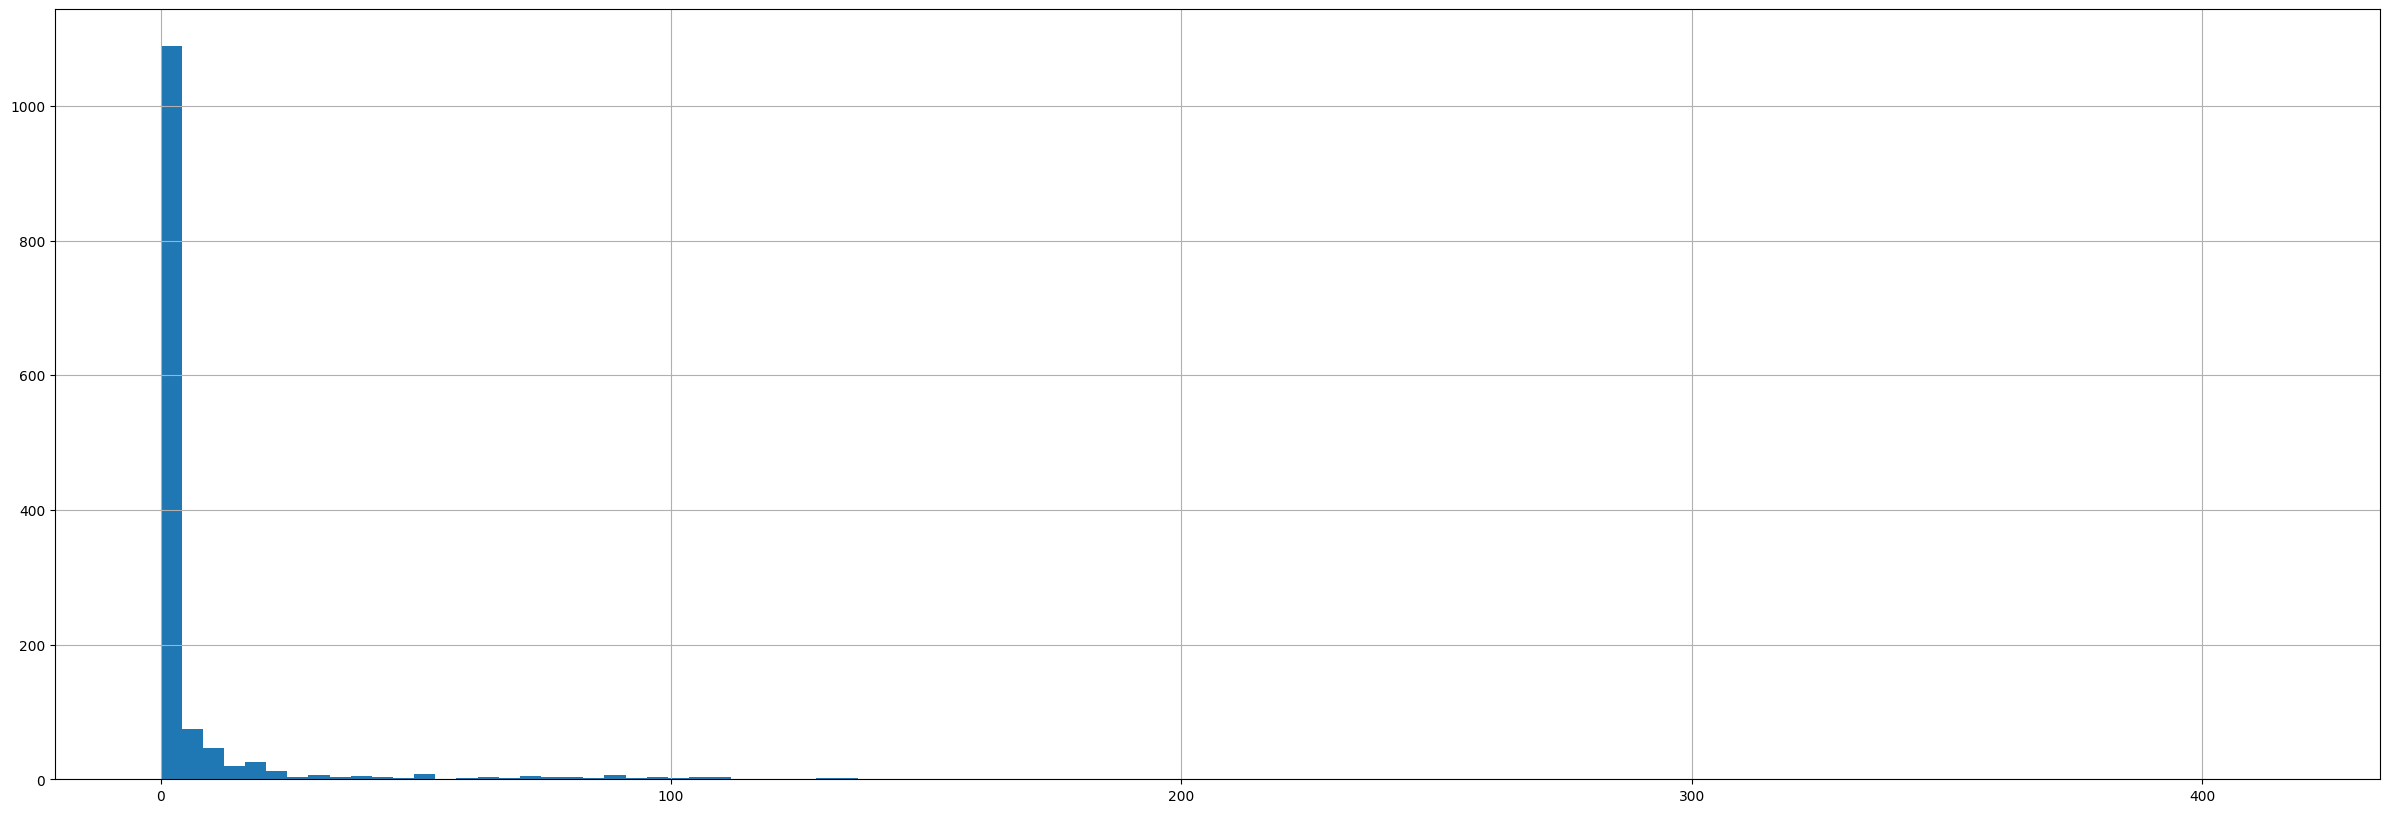

In [167]:
df2['diff_metros'].hist(bins=100,figsize=(30,10))


### Mapa de comparação: posições preditas vs. posições reais


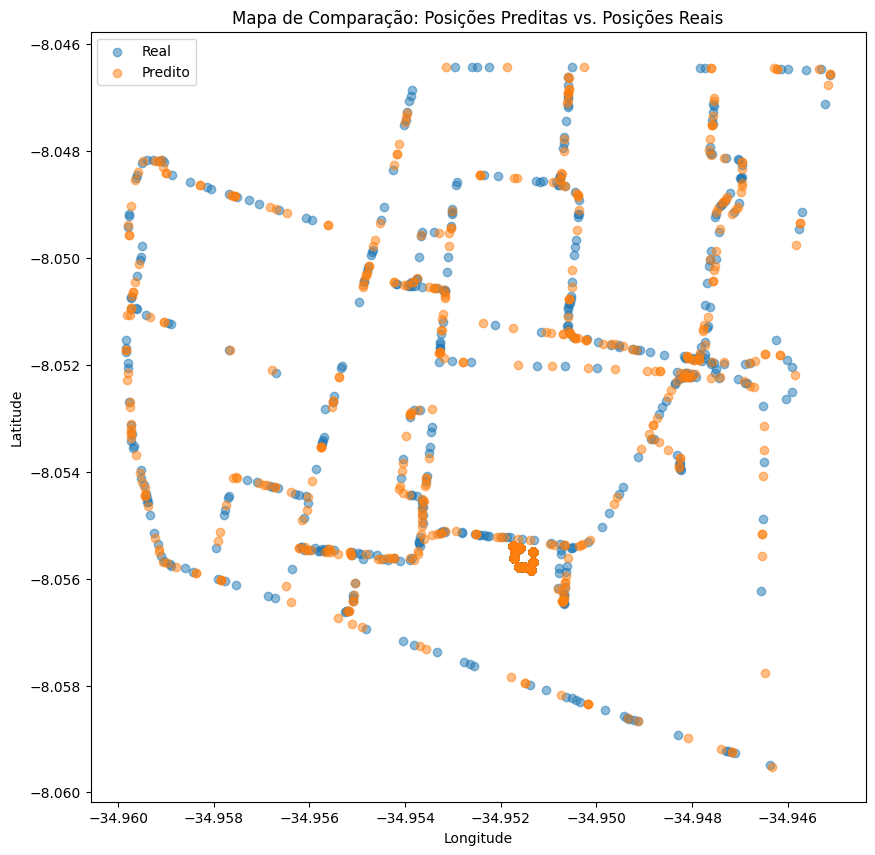

In [168]:
import numpy as np
Y_pred_array = np.array(Y_pred)
plt.figure(figsize=(10, 10))
plt.scatter(y_test['num_long_bts'], y_test['num_lat_bts'], label='Real', alpha=0.5)
plt.scatter(Y_pred_array[:, 1], Y_pred_array[:, 0], label='Predito', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapa de Comparação: Posições Preditas vs. Posições Reais')
plt.legend()
plt.show()




In [169]:
os = folium.Map(location=[-8.0556479,-34.9532624], zoom_start=15)

for _, row in df2[['num_lat_bts','num_long_bts']].iterrows():
    folium.CircleMarker(location=[row["num_lat_bts"], row["num_long_bts"]],radius=5, color = 'blue',fill_opacity=0.7).add_to(os)

for _, row in df2[['lat_pred','lon_pred']].iterrows():
    folium.CircleMarker(location=[row["lat_pred"], row["lon_pred"]],radius=5, color = 'orange',fill_opacity=0.3).add_to(os)
os

### Avaliação do Modelo

In [170]:
# Avaliação do modelo
y_test_subset = y_test[['num_lat_bts', 'num_long_bts']]

mse = mean_squared_error(y_test_subset, Y_pred_array)
mae = mean_absolute_error(y_test_subset, Y_pred_array)


In [171]:

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 3.4966407982268916e-07
Mean Absolute Error (MAE): 0.0001458019216556416


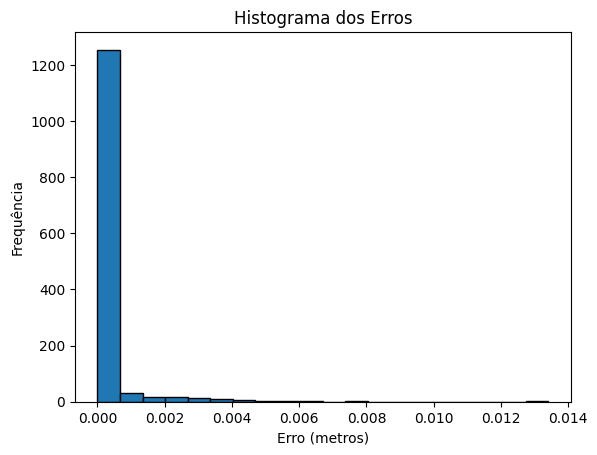

In [172]:
# Histograma e Box-Plot dos Erros
errors = np.sqrt(np.sum((Y_pred_array - y_test_subset) ** 2, axis=1))
plt.hist(errors, bins=20, edgecolor='k')
plt.xlabel('Erro (metros)')
plt.ylabel('Frequência')
plt.title('Histograma dos Erros')
plt.show()

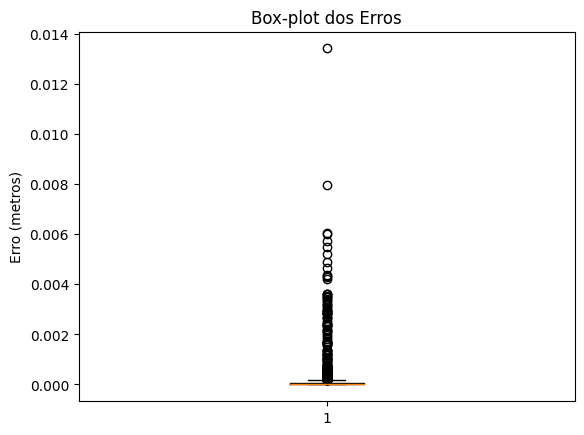

In [173]:
plt.boxplot(errors)
plt.ylabel('Erro (metros)')
plt.title('Box-plot dos Erros')
plt.show()

In [174]:
df2.head()

,id_ponto,num_lat_bts,num_long_bts,lat_pred,lon_pred,lat_diff,lon_diff,lat_diff_metros,lon_diff_metros,diff_metros
5997,9133,-8.048630,-34.952930,-8.048440,-34.952430,-0.00019,-0.00050,-5.8653,-15.4350,16.511843
4882,4445,-8.055506,-34.951693,-8.055506,-34.951693,0.00000,0.00000,0.0000,0.0000,0.000000
2955,6593,-8.055786,-34.951505,-8.055786,-34.951505,0.00000,0.00000,0.0000,0.0000,0.000000
2303,9502,-8.047130,-34.950590,-8.046910,-34.950600,-0.00022,0.00001,-6.7914,0.3087,6.798412
496,8192,-8.051920,-34.947800,-8.051910,-34.947850,-0.00001,0.00005,-0.3087,1.5435,1.574067


In [175]:
df_final = df2[['id_ponto','lat_pred','lon_pred']]
df_final.to_csv("../../project_files/03_processed_files/Resultados_Equipe1_MetodoFingerprint.csv")